# Prueba con nuevos datasets (propio) .pht

In [1]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    imagenes.append(img)  # Mantén la imagen como objeto PIL para aplicar transformaciones después
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Función para preprocesar imágenes de acuerdo con MobileNetV2
def preprocesar_imagenes(imagenes, nuevo_tamanio=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(nuevo_tamanio),  # Redimensionar la imagen
        transforms.ToTensor(),  # Convertir de PIL a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
    ])
    
    imagenes_preprocesadas = [transform(img) for img in imagenes]  # Aplica las transformaciones
    return torch.stack(imagenes_preprocesadas)  # Convierte la lista a un tensor

# Cargar y procesar las imágenes para inferencia
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Propio'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Preprocesar las imágenes de acuerdo con MobileNetV2
imagenes_tensor = preprocesar_imagenes(imagenes)

# Codificar las etiquetas (solo si necesitas evaluarlas después)
codificacion = {'Basket': 0, 'Campo_Futbol': 1, 'Cancha_Multiple': 2, 'Parque': 3, 'Tenis': 4}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

In [2]:
# Crear un dataset con las imágenes y las etiquetas para inferencia
dataset = TensorDataset(imagenes_tensor, torch.tensor(etiquetas_codificadas))

# Crear un DataLoader para cargar los datos en lotes
batch_size = 32  # Ajusta el tamaño del lote según la memoria disponible
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Cargar el modelo previamente entrenado de PyTorch
modelo_path = 'C:/Users/nicol/Desktop/Modelos/Propio/Propio_mobileNET.pth'
model = torch.load(modelo_path)
model.eval()  # Establecer el modelo en modo evaluación

# Desactivar el cálculo de gradientes para las predicciones (no se necesita para inferencia)
predicciones_clase = []

with torch.no_grad():
    for batch_imgs, _ in dataloader:  # _ significa que no necesitamos las etiquetas durante la inferencia
        batch_imgs = batch_imgs.to('cuda' if torch.cuda.is_available() else 'cpu')  # Mover imágenes a GPU si está disponible
        predicciones = model(batch_imgs)
        predicciones_clase_batch = torch.argmax(predicciones, dim=1).cpu().numpy()  # Convertir tensores a numpy array
        predicciones_clase.extend(predicciones_clase_batch)  # Guardar las predicciones de cada lote

# Convertir la lista a un numpy array para el cálculo de métricas
predicciones_clase = np.array(predicciones_clase)

C:\Users\nicol\AppData\Local\Temp\ipykernel_2352\2406619958.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(modelo_path)


In [3]:
# Comparar predicciones con etiquetas originales
accuracy = accuracy_score(etiquetas_codificadas, predicciones_clase)
precision = precision_score(etiquetas_codificadas, predicciones_clase, average=None)  
recall = recall_score(etiquetas_codificadas, predicciones_clase, average=None)        
f1 = f1_score(etiquetas_codificadas, predicciones_clase, average=None)                

# Reporte por clase
reporte_clases = classification_report(etiquetas_codificadas, predicciones_clase)

# Mostrar resultados
print("Accuracy:", accuracy)
print("\nPrecision por clase:", precision)
print("\nRecall por clase:", recall)
print("\nF1-Score por clase:", f1)
print("\nReporte completo:\n", reporte_clases)

Accuracy: 0.9912023460410557

Precision por clase: [0.97275204 1.         0.98765432 0.99696049 1.        ]

Recall por clase: [0.9972067  0.98373984 0.97560976 1.         1.        ]

F1-Score por clase: [0.98482759 0.99180328 0.98159509 0.99847793 1.        ]

Reporte completo:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       358
           1       1.00      0.98      0.99       369
           2       0.99      0.98      0.98       328
           3       1.00      1.00      1.00       328
           4       1.00      1.00      1.00       322

    accuracy                           0.99      1705
   macro avg       0.99      0.99      0.99      1705
weighted avg       0.99      0.99      0.99      1705



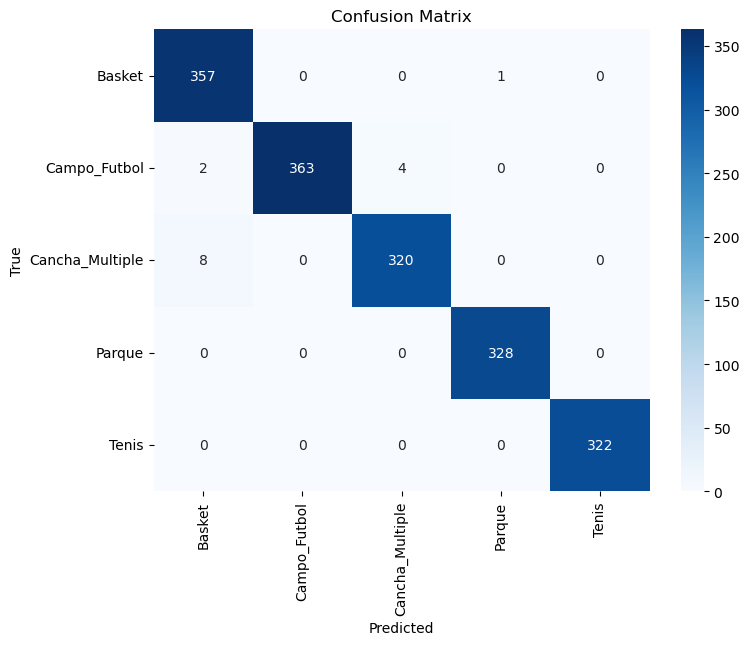

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generar la matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_codificadas, predicciones_clase)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=codificacion.keys(), yticklabels=codificacion.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()